## Import Libraries
Import necessary libraries for data processing, model building, and visualization (os, re, random, numpy, tensorflow, keras, scikit-learn, matplotlib, seaborn).

In [2]:
import os
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Set Hyperparameters and Filenames
Define the hyperparameters of the dataset, including phonemes and classes. Load the training data and parse the filenames.

In [4]:
PHONEMES = ['_', 'B', 'D', 'F', 'G', 'HH', 'JH', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Y', 'Z', 'CH', 'SH', 'NG', 'DH', 'TH', 'ZH', 'WH', 'AA', 'AI(R)', 'I(R)', 'A(R)', 'ER', 'EY', 'IY', 'AY', 'OW', 'UW', 'AE', 'EH', 'IH', 'AO', 'AH', 'UH', 'OO', 'AW', 'OY']

CLASSES = len(PHONEMES)

def get_files_with_prefix(directory, prefix):
    files = os.listdir(directory)
    filtered_files = [file for file in files if file.startswith(prefix)]
    return filtered_files

directory = "/content"
X_filename = get_files_with_prefix(directory, f"X_all44")[0]
y_filename = get_files_with_prefix(directory, f"y_all44")[0]

print(f"X_filename: {X_filename}")
print(f"y_filename: {y_filename}")
print(f"CLASSES: {CLASSES}")

X_filename: X_all44_3220_4_5_5.npy
y_filename: y_all44_3220_4_5_5.npy
CLASSES: 45


## Parse Filename

In [6]:
def parse_filename(filename):
    # Regular expression pattern to extract the required information from the filename
    pattern = r"X_all44_(\d+)_(\d+)_(\d+)_(\d+).npy"

    # Use regular expression to search and extract the required information
    match = re.search(pattern, filename)

    if match:
        num_examples = int(match.group(1))
        channels = int(match.group(2))
        size = int(match.group(3))

        return num_examples, channels, size
    else:
        raise ValueError("Invalid filename format")

NUM_EXAMPLES, CHANNELS, SIZE = parse_filename(X_filename)

print("NUM_EXAMPLES:", NUM_EXAMPLES)
print("channels:", CHANNELS)
print("size:", SIZE)

NUM_EXAMPLES: 3220
channels: 4
size: 5


## Train/Test Split

In [7]:
# Load the training data
X_train_og = np.load(X_filename)
y_train_og = np.load(y_filename)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_train_og, y_train_og, test_size=0.2, random_state=489)

# Prepare the data - N training examples, 4 channels (muscle groups) per example, each SIZE timesteps long
X_train = X_train.reshape(-1, CHANNELS, SIZE)
X_test = X_test.reshape(-1, CHANNELS, SIZE)

print(f"X_train.shape: {X_train.shape} - {X_train.shape[0]} training examples")
print(f"X_test.shape: {X_test.shape} - {X_test.shape[0]} testing examples")

X_train.shape: (2576, 4, 5) - 2576 training examples
X_test.shape: (644, 4, 5) - 644 testing examples


## Original/Training/Test Set Distributions
Print info about training example distrubtions across phonemes/classes.

In [9]:
# # UNCOMMENT FOR SET DISTRIBUTIONS

# # Count the occurrences of each class in the training set
# y_og_counts = Counter(y_train_og)

# # Count the occurrences of each class in the training set
# y_train_counts = Counter(y_train)

# # Count the occurrences of each class in the test set
# y_test_counts = Counter(y_test)

# # Print the occurrences
# print("Occurrences in the original set:")
# for phoneme_index, count in sorted(y_og_counts.items()):
#     print(f"\tPhoneme {PHONEMES[phoneme_index]}: {count}")

# print("Occurrences in the training set:")
# for phoneme_index, count in sorted(y_train_counts.items()):
#     print(f"\tPhoneme {PHONEMES[phoneme_index]}: {count}")

# print("Occurrences in the test set:")
# for phoneme_index, count in sorted(y_test_counts.items()):
#     print(f"\tPhoneme {PHONEMES[phoneme_index]}: {count}")

## Define the Model
Create a sequential model using various layers such as Conv1D, Dropout, LSTM, and Dense, then compile the model with loss, optimizer, and metrics.

In [18]:
# Define the model
model = tf.keras.Sequential([
    layers.Conv1D(256, 3, activation='relu', input_shape=(CHANNELS, SIZE), padding='same'),
    layers.Dropout(0.5),
    # layers.Conv1D(256, 3, activation='relu', strides=2, padding='same'),
    # layers.Dropout(0.5),
    # layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4)),
    # layers.Dropout(0.5),
    layers.LSTM(128, kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    # layers.Dense(128, activation='relu'),
    layers.Dense(CLASSES, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 4, 256)            4096      
                                                                 
 dropout_14 (Dropout)        (None, 4, 256)            0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 45)                5805      
                                                                 
Total params: 223,533
Trainable params: 223,533
Non-tr

## Define Early Stopping callback
Define an EarlyStopping callback function to prevent overfitting.

In [19]:
# Define Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=250,
    mode='max',
    restore_best_weights=True
)

## Train the Model
Fit the model on the training data and validate it on the testing data using the early stopping callback.

In [20]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=2000,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)

Epoch 1/2000
21/21 [==============================] - 5s 66ms/step - loss: 3.8252 - accuracy: 0.0248 - val_loss: 3.7877 - val_accuracy: 0.0171
Epoch 2/2000
21/21 [==============================] - 1s 38ms/step - loss: 3.7475 - accuracy: 0.0260 - val_loss: 3.6261 - val_accuracy: 0.0776
Epoch 3/2000
21/21 [==============================] - 1s 34ms/step - loss: 3.4781 - accuracy: 0.0718 - val_loss: 3.0637 - val_accuracy: 0.1149
Epoch 4/2000
21/21 [==============================] - 1s 35ms/step - loss: 2.8888 - accuracy: 0.1134 - val_loss: 2.4149 - val_accuracy: 0.1475
Epoch 5/2000
21/21 [==============================] - 1s 36ms/step - loss: 2.5085 - accuracy: 0.1518 - val_loss: 2.1093 - val_accuracy: 0.2469

...

Epoch 738/2000
21/21 [==============================] - 1s 40ms/step - loss: 0.1978 - accuracy: 0.9363 - val_loss: 0.1079 - val_accuracy: 0.9752
Epoch 739/2000
21/21 [==============================] - 1s 42ms/step - loss: 0.1719 - accuracy: 0.9437 - val_loss: 0.1098 - val_accura

## Evaluate the Model

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Example Count: {len(y_test)}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Correctness: {int(np.round(test_accuracy * len(y_test)))} / {len(y_test)}")

Test Example Count: 644
Test Loss: 0.11591044068336487
Test Accuracy: 0.9813664555549622
Test Correctness: 632 / 644


## Plotting Training and Validation Loss and Accuracy
Create plots for training and validation loss, as well as training and validation accuracy.

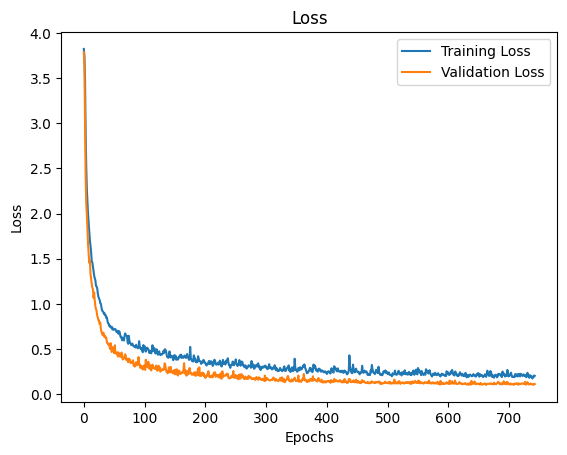

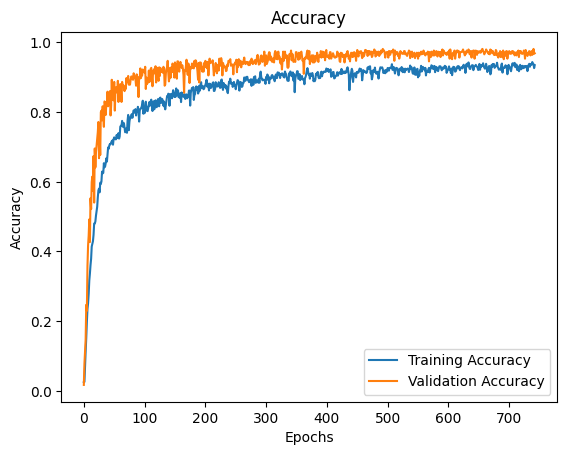

In [22]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Calculate and Display Confusion Matrix
Get the predicted classes for the entire test set, then create and display the confusion matrix using a heatmap.

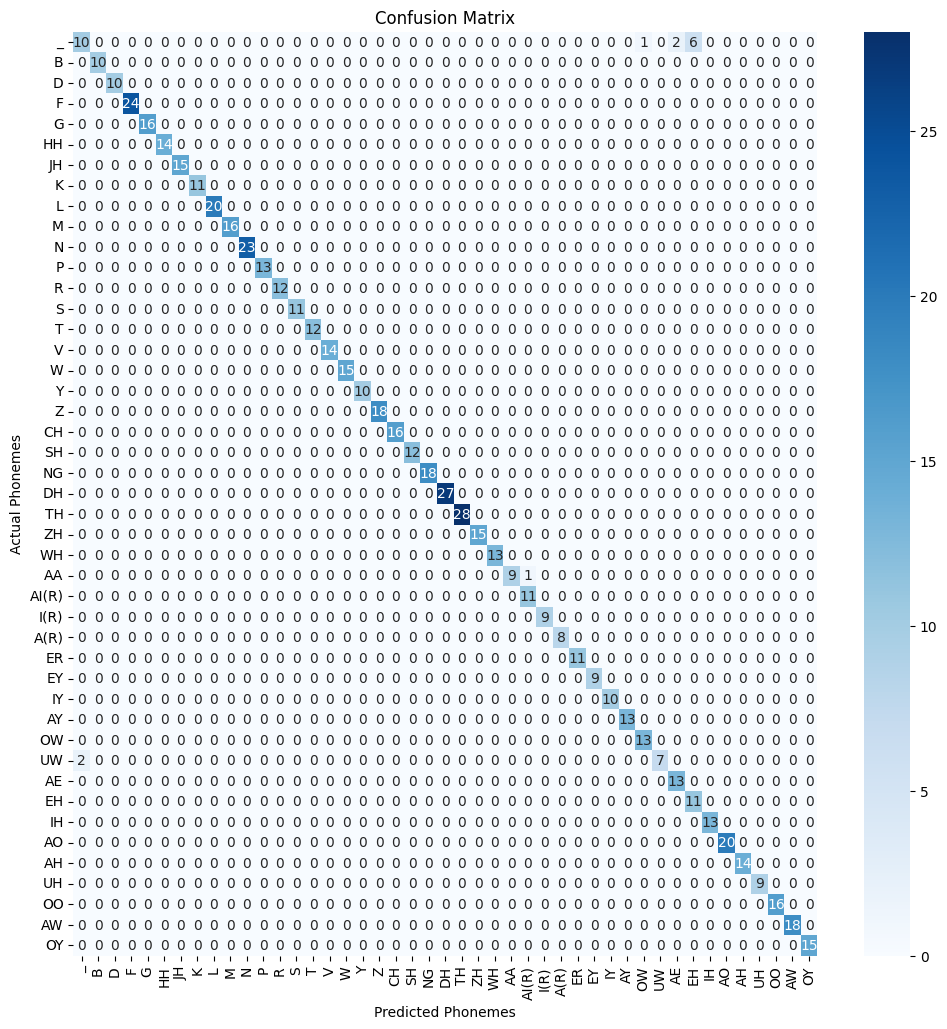

In [23]:
# Get the predicted classes for the entire test set
y_predicted = model.predict(X_test, verbose=0)
y_predicted_classes = np.argmax(y_predicted, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_predicted_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(
                      cm,
                      annot=True,
                      cmap="Blues",
                      fmt='d',  # <- Set integer format for the annotations
                      xticklabels=[PHONEMES[i] for i in range(CLASSES)],
                      yticklabels=[PHONEMES[i] for i in range(CLASSES)],
)

# Modify the rotation of the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Phonemes")
plt.ylabel("Actual Phonemes")
plt.show()

## Test Model on Random Examples
Choose some random examples from the test set and display their actual and predicted phonemes.

In [24]:
# Choose 10 random examples from the test set
random_indices = random.sample(range(X_test.shape[0]), 10)
random_X = X_test[random_indices]
random_y_actual = y_test[random_indices]

# Predict the phoneme using the model
predictions = model.predict(random_X, verbose=0)
random_y_predicted = np.argmax(predictions, axis=1)

# Show actual and predicted phoneme for each picked example
for i in range(10):
    print(f"Example {i + 1}:")
    print(f"\tActual Phoneme: {PHONEMES[random_y_actual[i]]}")
    print(f"\tPredicted Phoneme: {PHONEMES[random_y_predicted[i]]}")

Example 1:
	Actual Phoneme: I(R)
	Predicted Phoneme: I(R)
Example 2:
	Actual Phoneme: A(R)
	Predicted Phoneme: A(R)
Example 3:
	Actual Phoneme: T
	Predicted Phoneme: T
Example 4:
	Actual Phoneme: R
	Predicted Phoneme: R
Example 5:
	Actual Phoneme: T
	Predicted Phoneme: T
Example 6:
	Actual Phoneme: AW
	Predicted Phoneme: AW
Example 7:
	Actual Phoneme: TH
	Predicted Phoneme: TH
Example 8:
	Actual Phoneme: M
	Predicted Phoneme: M
Example 9:
	Actual Phoneme: K
	Predicted Phoneme: K
Example 10:
	Actual Phoneme: AY
	Predicted Phoneme: AY


## Save Model
Save to a formatted filename path, store not just weights but also hyperparameters for simpler model loading.

In [25]:
  # Create filepath
filepath = f'LSTM_all44_seed489_{SIZE}_{SIZE}_224k'

# Saving the model
model.save(filepath)